# Pré-Processamento

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

Dataset: https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset?resource=download

In [5]:
data = pd.read_csv('synthetic_coffee_health_10000.csv', sep = ',')

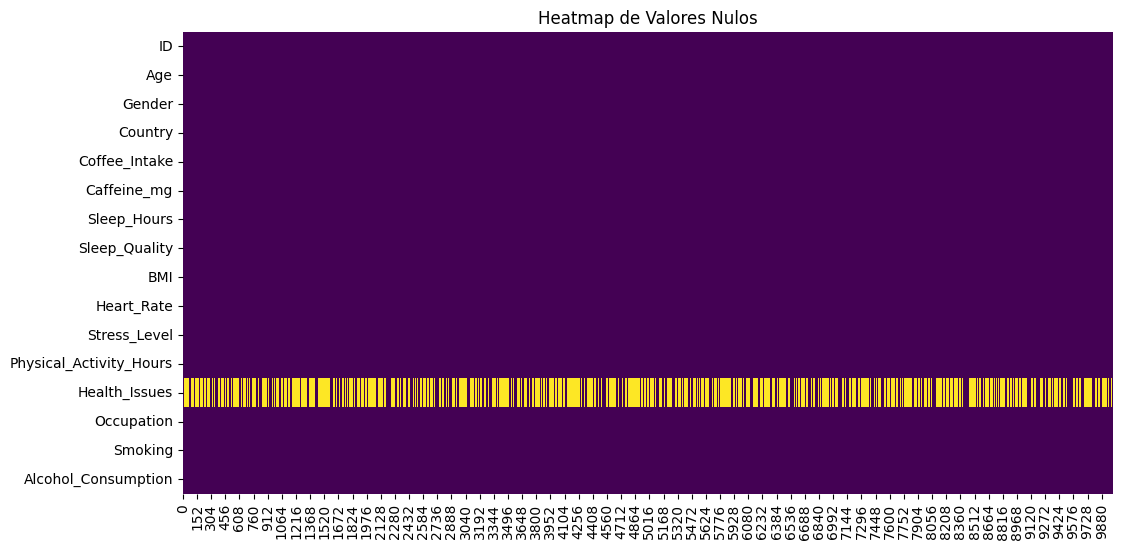

In [113]:
# plotar heatmap de valores nulos
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull().T, cbar=False, cmap='viridis')
plt.title('Heatmap de Valores Nulos')
plt.show()

In [6]:
dataWithoutHealthIssues = data.drop(columns=['Health_Issues'])
dataDroppedNA = data.dropna()
dataWithoutHealthIssues.shape, dataDroppedNA.shape

((10000, 15), (4059, 16))

Se removermos a feature "Health_Issues", a qual é a única que possui valores nulo, teríamos 10000 ocorrências para tentar prever a "Sleep_Quality".

Se mantivermos a feature "Health_Issues", e jogar fora todas as ocorrências em que ela é nula, ainda teremos 4059 ocorrências para prever "Sleep_Quality". O que não me parece ruim.

<Axes: xlabel='Sleep_Quality'>

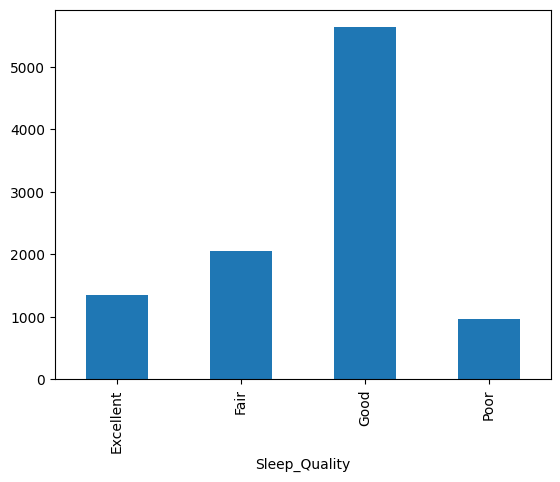

In [115]:
dataWithoutHealthIssues["Sleep_Quality"].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='Sleep_Quality'>

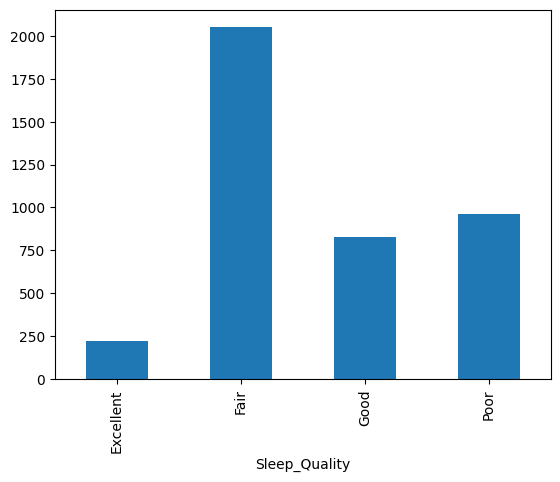

In [116]:
dataDroppedNA["Sleep_Quality"].value_counts().sort_index().plot(kind='bar')

Em ambos os casos, as classes continuam bem desbalanceadas, então não faz muita diferença qual corte escolher. Vamos trabalhar com o dataset com 10000 pra ficar redondo.

Agora, avaliando os valores das colunas:

In [ ]:
dataWithoutHealthIssues["Age"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Gender"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Country"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Coffee_Intake"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Caffeine_mg"].value_counts().sort_index().plot(kind='line', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Sleep_Hours"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))


In [ ]:
dataWithoutHealthIssues["Sleep_Quality"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["BMI"].value_counts().sort_index().plot(kind='line', figsize=(12, 3))


In [ ]:
dataWithoutHealthIssues["Heart_Rate"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Stress_Level"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Physical_Activity_Hours"].value_counts().sort_index().plot(kind='line', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Occupation"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Smoking"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues["Alcohol_Consumption"].value_counts().sort_index().plot(kind='bar', figsize=(12, 3))

In [ ]:
dataWithoutHealthIssues.head()

## Processamento para o KNN

- Age: numérica contínua. Normalizar.
- Gender: categórica nominal com 3 valores únicos. Aplicar OneHot. 
- Country: categórica nominal com 20 valores únicos. Aplicar OneHot. (Considerar agrupar por continentes, perguntar ao professor).
- Coffee_Intake: numérica contínua. Normalizar. (Conversar com o professor se "cortar" os extremos pode ser bom para o treinamento).
- Caffeine_mg: numérica contínua. Normalizar.
- Sleep_Hours: numérica contínua. Normalizar.
- Sleep_Quality: categórica ordinal e target dos modelos. Só converter para numérica manualmente.
- BMI: numérica contínua. Normalizar.
- Heart_Rate: numérica contínua. Normalizar.
- Stress_Level: categórica ordinal com 3 valores únicos. Converter para numérica manualmente.
- Physical_Activity_Hours: numérica contínua. Normalizar.
- Occupation: categórica nominal com 5 valores únicos: Aplicar OneHot.
- Smoking: binária numérica. Fazer nada.
- Alcohol_Consumption: binária numérica. Fazer nada.

OBS: vou remover a coluna de país para verificar se melhora as métricas do KNN

In [42]:
dataKNN = dataWithoutHealthIssues.copy()

dataKNN.drop(columns=['Country'], inplace=True) # experimento

# OneHot para variáveis categóricas nominais
# dataEnconded = pd.get_dummies(dataEnconded, columns=['Gender', 'Country', 'Occupation'], drop_first=False, dtype=int)
dataKNN = pd.get_dummies(dataKNN, columns=['Gender', 'Occupation'], drop_first=False, dtype=int) # experimento

# Normalização das variáveis contínuas
scaler = MinMaxScaler()
columnsToNormalize = ['Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours']
dataKNN[columnsToNormalize] = scaler.fit_transform(dataKNN[columnsToNormalize])

# Conversão manual das colunas ordinais Sleep_Quality e Stress_Level para valores numéricos
sleepQualityMap = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Excellent': 3
}

stressLevelMap = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

dataKNN['Sleep_Quality'] = dataKNN['Sleep_Quality'].map(sleepQualityMap)
dataKNN['Stress_Level'] = dataKNN['Stress_Level'].map(stressLevelMap)

dataKNN.drop(columns=['ID'], inplace=True)

dataKNN.head()

,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Smoking,Alcohol_Consumption,Gender_Female,Gender_Male,Gender_Other,Occupation_Healthcare,Occupation_Office,Occupation_Other,Occupation_Service,Occupation_Student
0,40,0.426829,0.420479,0.642857,2,0.426724,0.474576,0,0.966667,0,0,0,1,0,0,0,1,0,0
1,33,0.121951,0.120595,0.457143,2,0.215517,0.288136,0,0.733333,0,0,0,1,0,0,0,0,1,0
2,42,0.646341,0.645521,0.414286,1,0.331897,0.152542,1,0.746667,0,0,0,1,0,0,1,0,0,0
3,53,0.317073,0.319364,0.614286,2,0.418103,0.355932,0,0.440000,0,0,0,1,0,0,0,1,0,0
4,32,0.378049,0.381904,0.328571,1,0.392241,0.440678,1,0.566667,0,1,1,0,0,0,0,0,0,1


In [ ]:
# divide o dataset em treino, validacao e teste
train, test = train_test_split(dataKNN, test_size=0.2, stratify=dataKNN["Sleep_Quality"])
train, validation = train_test_split(train, test_size=0.2, stratify=train["Sleep_Quality"])
train.shape, validation.shape, test.shape

In [ ]:
train.to_csv("trainKNN.csv", index=False)
validation.to_csv("validationKNN.csv", index=False)
test.to_csv("testKNN.csv", index=False)

## Processamento para Naive Bayes

Aqui optamos por converter valores numéricos para intervalar, através de discretizações. 

- Age: numérica contínua. Discretizar.
- Gender: categórica nominal com 3 valores únicos. Converter para numérica.
- Country: categórica nominal com 20 valores únicos. Converter para numérica.
- Coffee_Intake: numérica contínua. Discretizar.
- Caffeine_mg: numérica contínua. Discretizar.
- Sleep_Hours: numérica contínua. Discretizar.
- Sleep_Quality: categórica ordinal e target dos modelos. Converter para numérica.
- BMI: numérica contínua. Discretizar.
- Heart_Rate: numérica contínua. Discretizar.
- Stress_Level: categórica ordinal com 3 valores únicos. Converter para numérica.
- Physical_Activity_Hours: numérica contínua. Discretizar.
- Occupation: categórica nominal com 5 valores únicos. Converter para numérica.
- Smoking: binária numérica. Fazer nada.
- Alcohol_Consumption: binária numérica. Fazer nada.

In [133]:
dataNB = dataWithoutHealthIssues.copy()

# Colunas a serem discretizadas
columns_to_discretize = [
    'Age',
    'Coffee_Intake',
    'Caffeine_mg',
    'Sleep_Hours',
    'BMI',
    'Heart_Rate',
    'Physical_Activity_Hours'
]

# Discretização usando qcut (quantis) para criar 4 bins para cada coluna
for col in columns_to_discretize:
    dataNB[col] = pd.qcut(dataNB[col], q=4, labels=False, duplicates='drop')

# Colunas categóricas nominais a serem encodadas
columns_to_encode = [
    'Gender',
    'Country',
    'Occupation',
]

encoder = OrdinalEncoder()
dataNB[columns_to_encode] = encoder.fit_transform(dataNB[columns_to_encode])

# Conversão manual das colunas ordinais Sleep_Quality e Stress_Level para valores numéricos
sleepQualityMap = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Excellent': 3
}

stressLevelMap = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

dataNB['Sleep_Quality'] = dataNB['Sleep_Quality'].map(sleepQualityMap)
dataNB['Stress_Level'] = dataNB['Stress_Level'].map(stressLevelMap)

dataNB.drop(columns=['ID'], inplace=True)

dataNB.head()

,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Occupation,Smoking,Alcohol_Consumption
0,2,1.0,7.0,2,2,2,2,2,3,0,3,2.0,0,0
1,1,1.0,7.0,0,0,1,2,0,1,0,2,3.0,0,0
2,2,1.0,2.0,3,3,1,1,1,0,1,2,1.0,0,0
3,3,1.0,7.0,2,2,2,2,2,1,0,1,2.0,0,0
4,1,0.0,15.0,2,2,0,1,2,2,1,2,4.0,0,1


In [ ]:
train, test = train_test_split(dataNB, test_size=0.2, stratify=dataNB["Sleep_Quality"])
train, validation = train_test_split(train, test_size=0.2, stratify=train["Sleep_Quality"])
train.shape, validation.shape, test.shape

((6400, 14), (1600, 14), (2000, 14))

In [135]:
train.to_csv("trainNB.csv", index=False)
validation.to_csv("validationNB.csv", index=False)
test.to_csv("testNB.csv", index=False)

## Processamento para Árvore de Decisão

- Age: numérica contínua. Fazer nada.
- Gender: categórica nominal com 3 valores únicos. Converter para numérica.
- Country: categórica nominal com 20 valores únicos. Converter para numérica.
- Coffee_Intake: numérica contínua. Fazer nada.
- Caffeine_mg: numérica contínua. Fazer nada.
- Sleep_Hours: numérica contínua. Fazer nada.
- Sleep_Quality: categórica ordinal e target dos modelos. Converter para numérica.
- BMI: numérica contínua. Fazer nada.
- Heart_Rate: numérica contínua. Fazer nada.
- Stress_Level: categórica ordinal com 3 valores únicos. Converter para numérica.
- Physical_Activity_Hours: numérica contínua. Fazer nada.
- Occupation: categórica nominal com 5 valores únicos. Converter para numérica.
- Smoking: binária numérica. Fazer nada.
- Alcohol_Consumption: binária numérica. Fazer nada.

In [7]:
dataAD = dataWithoutHealthIssues.copy()

# Colunas categóricas nominais a serem encodadas
columns_to_encode = [
    'Gender',
    'Country',
    'Occupation',
]

encoder = OrdinalEncoder()
dataAD[columns_to_encode] = encoder.fit_transform(dataAD[columns_to_encode])

# Conversão manual das colunas ordinais Sleep_Quality e Stress_Level para valores numéricos
sleepQualityMap = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Excellent': 3
}

stressLevelMap = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

dataAD['Sleep_Quality'] = dataAD['Sleep_Quality'].map(sleepQualityMap)
dataAD['Stress_Level'] = dataAD['Stress_Level'].map(stressLevelMap)

dataAD.drop(columns=['ID'], inplace=True)

dataAD.head()

,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Occupation,Smoking,Alcohol_Consumption
0,40,1.0,7.0,3.5,328.1,7.5,2,24.9,78,0,14.5,2.0,0,0
1,33,1.0,7.0,1.0,94.1,6.2,2,20.0,67,0,11.0,3.0,0,0
2,42,1.0,2.0,5.3,503.7,5.9,1,22.7,59,1,11.2,1.0,0,0
3,53,1.0,7.0,2.6,249.2,7.3,2,24.7,71,0,6.6,2.0,0,0
4,32,0.0,15.0,3.1,298.0,5.3,1,24.1,76,1,8.5,4.0,0,1


In [8]:
# divide o dataset em treino, validacao e teste
train, test = train_test_split(dataAD, test_size=0.2, stratify=dataAD["Sleep_Quality"])
train, validation = train_test_split(train, test_size=0.2, stratify=train["Sleep_Quality"])
train.shape, validation.shape, test.shape

((6400, 14), (1600, 14), (2000, 14))

In [9]:
train.to_csv("trainAD.csv", index=False)
validation.to_csv("validationAD.csv", index=False)
test.to_csv("testAD.csv", index=False)

# KNN

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import plotly.graph_objects as go

## Treinamento

In [ ]:
train = pd.read_csv("trainKNN.csv")
validation = pd.read_csv("validationKNN.csv")
test = pd.read_csv("testKNN.csv")

In [ ]:
# Avaliação no conjunto de teste
X_test = test.drop(columns=['Sleep_Quality'])
y_test = test['Sleep_Quality']
y_test_pred = knn_final.predict(X_test)

print('Acurácia:', accuracy_score(y_test, y_test_pred))
print('Precisão:', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_test_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_test_pred, average='weighted'))

In [ ]:
# Separa features e target
X_train = train.drop(columns=['Sleep_Quality'])
y_train = train['Sleep_Quality']
X_val = validation.drop(columns=['Sleep_Quality'])
y_val = validation['Sleep_Quality']

In [ ]:
# Teste do cotovelo: varie o número de vizinhos e avalia a acurácia, precisão, recall e f1
k_range = range(1, 100)
scores = []
precisions = []
recalls = []
f1s = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    scores.append(accuracy_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred, average='weighted'))
    recalls.append(recall_score(y_val, y_pred, average='weighted'))
    f1s.append(f1_score(y_val, y_pred, average='weighted'))

In [ ]:
# Gráfico interativo do teste do cotovelo
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(k_range), y=scores, mode='lines', name='Acurácia'))
fig.add_trace(go.Scatter(x=list(k_range), y=precisions, mode='lines', name='Precisão'))
fig.add_trace(go.Scatter(x=list(k_range), y=recalls, mode='lines', name='Recall'))
fig.add_trace(go.Scatter(x=list(k_range), y=f1s, mode='lines', name='F1-score'))
fig.update_layout(
    title='Teste do Cotovelo para KNN - Todas Métricas',
    xaxis_title='Número de Vizinhos (k)',
    yaxis_title='Métrica na validação',
    legend_title='Métrica',
    template='plotly_white'
)
fig.show()

In [ ]:
# Printa as métricas de avaliação de um determinado k
k = 5
print("Acurácia: ", scores[k-1])
print("Precisão: ", precisions[k-1])
print("Recall: ", recalls[k-1])
print("F1-score: ", f1s[k-1])

In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=k)
knn_final.fit(X_train, y_train)

In [ ]:
# Avaliação no conjunto de teste
X_test = test.drop(columns=['Sleep_Quality'])
y_test = test['Sleep_Quality']
y_test_pred = knn_final.predict(X_test)

print('Acurácia:', accuracy_score(y_test, y_test_pred))
print('Precisão:', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_test_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_test_pred, average='weighted'))

- Como as classes são desbalanceadas, estarei olhando para o f1-score como métrica ideal. 
    - Usando o algoritmo sem a aplicação de pesos e um K = 5, foi obtido um f1 de 0.80. Parece bom. 
        - Acurácia: 0.841
        - Precisão: 0.7919884665305217
        - Recall: 0.841
        - F1-score: 0.8039855637073263 (sem a coluna de países que dobrava o número de features/dimensões, subiu para 0.8147621633227298)

    - Usando o algoritmo com a aplicação de pesos e um K = 5, foi obtido um f1 de 0.80.
        - Acurácia: 0.833
        - Precisão: 0.790764963106682
        - Recall: 0.833
        - F1-score: 0.8012910928757704 (sem a coluna de países que dobrava o número de features/dimensões, se manteve em 0.8067363049789931)
        
- Em todos os casos as métricas da validação e teste estavam muito similares. Logo ele não parece ter overfitado. 

## Interpretação

# Naive Bayes

In [ ]:
import pandas as pd
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Treinamento

In [ ]:
train = pd.read_csv("trainNB.csv")
validation = pd.read_csv("validationNB.csv")
test = pd.read_csv("testNB.csv")

In [138]:
# Separa features e target
X_train = train.drop(columns=['Sleep_Quality'])
y_train = train['Sleep_Quality']

X_val = validation.drop(columns=['Sleep_Quality'])
y_val = validation['Sleep_Quality']

X_test = test.drop(columns=['Sleep_Quality'])
y_test = test['Sleep_Quality']

In [139]:
# Treina o modelo Naive Bayes
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,min_categories,None


In [140]:
# Faz predições no conjunto de validação
y_val_pred = nb_model.predict(X_val)

# Avalia o modelo na validação
print("--- Métricas na Validação ---")
print('Acurácia:', accuracy_score(y_val, y_val_pred))
print('Precisão:', precision_score(y_val, y_val_pred, average='weighted'))
print('Recall:', recall_score(y_val, y_val_pred, average='weighted'))
print('F1-score:', f1_score(y_val, y_val_pred, average='weighted'))

--- Métricas na Validação ---
Acurácia: 0.905
Precisão: 0.9123160337379703
Recall: 0.905
F1-score: 0.9078183417267054


In [141]:
# Faz predições no conjunto de teste
y_test_pred = nb_model.predict(X_test)

# Avalia o modelo no teste
print("\n--- Métricas no Teste ---")
print('Acurácia:', accuracy_score(y_test, y_test_pred))
print('Precisão:', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_test_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_test_pred, average='weighted'))


--- Métricas no Teste ---
Acurácia: 0.9055
Precisão: 0.9155555386372288
Recall: 0.9055
F1-score: 0.9090791800232763


- Novamente, como temos classes desbalanceadas, estaremos olhando para o f1. Usando o modelo padrão, sem atribuir valores especificos aos hiperparametros, obtivemos:
    - Métricas na Validação
        - Acurácia: 0.905
        - Precisão: 0.9123160337379703
        - Recall: 0.905
        - F1-score: 0.9078183417267054

    - Métricas no Teste
        - Acurácia: 0.9055
        - Precisão: 0.9155555386372288
        - Recall: 0.9055
        - F1-score: 0.9090791800232763
        
- Resultados excelentes. Como não há diferenças entre validação e teste, ele generalizou bem.

OBS: segundo a documentação, o role de Laplace para remover probabilidades 0 é aplicado por padrão. Nos hiperparametros ele é o alpha, que igual a 1 ativa o Laplace.

## Interpretação

# Árvore de Decisão

In [35]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Treinamento

In [2]:
train = pd.read_csv("trainAD.csv")
validation = pd.read_csv("validationAD.csv")
test = pd.read_csv("testAD.csv")

In [12]:
# Separa features e target
X_train = train.drop(columns=['Sleep_Quality'])
y_train = train['Sleep_Quality']

X_val = validation.drop(columns=['Sleep_Quality'])
y_val = validation['Sleep_Quality']

X_test = test.drop(columns=['Sleep_Quality'])
y_test = test['Sleep_Quality']

In [36]:
# Teste do cotovelo para a profundidade da árvore
depth_range = range(1, 21) # Testar profundidades de 1 a 20
scores_val = []
precisions_val = []
recalls_val = []
f1s_val = []

for depth in depth_range:
    ad_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    ad_model.fit(X_train, y_train)
    y_pred_val = ad_model.predict(X_val)
    scores_val.append(accuracy_score(y_val, y_pred_val))
    precisions_val.append(precision_score(y_val, y_pred_val, average='weighted'))
    recalls_val.append(recall_score(y_val, y_pred_val, average='weighted'))
    f1s_val.append(f1_score(y_val, y_pred_val, average='weighted'))

# Gráfico interativo do teste do cotovelo
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(depth_range), y=scores_val, mode='lines', name='Acurácia'))
fig.add_trace(go.Scatter(x=list(depth_range), y=precisions_val, mode='lines', name='Precisão'))
fig.add_trace(go.Scatter(x=list(depth_range), y=recalls_val, mode='lines', name='Recall'))
fig.add_trace(go.Scatter(x=list(depth_range), y=f1s_val, mode='lines', name='F1-score'))
fig.update_layout(
    title='Teste do Cotovelo para Árvore de Decisão - Profundidade Máxima',
    xaxis_title='Profundidade Máxima da Árvore',
    yaxis_title='Métrica na Validação',
    legend_title='Métrica',
    template='plotly_white'
)
fig.show()

c:\Users\gabri\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [38]:
# Treina o modelo de Árvore de Decisão
ad_model = DecisionTreeClassifier(random_state=42, max_depth=2)
ad_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [39]:
# Faz predições no conjunto de validação
y_val_pred = ad_model.predict(X_val)

# Avalia o modelo na validação
print("- Métricas na Validação")
print('     - Acurácia:', accuracy_score(y_val, y_val_pred))
print('     - Precisão:', precision_score(y_val, y_val_pred, average='weighted'))
print('     - Recall:', recall_score(y_val, y_val_pred, average='weighted'))
print('     - F1-score:', f1_score(y_val, y_val_pred, average='weighted'))

- Métricas na Validação
     - Acurácia: 0.99125
     - Precisão: 0.9913837336244541
     - Recall: 0.99125
     - F1-score: 0.9911371597686085


In [40]:
# Faz predições no conjunto de teste
y_test_pred = ad_model.predict(X_test)

# Avalia o modelo no teste
print("- Métricas no Teste ")
print('     - Acurácia:', accuracy_score(y_test, y_test_pred))
print('     - Precisão:', precision_score(y_test, y_test_pred, average='weighted'))
print('     - Recall:', recall_score(y_test, y_test_pred, average='weighted'))
print('     - F1-score:', f1_score(y_test, y_test_pred, average='weighted'))

- Métricas no Teste 
     - Acurácia: 0.9945
     - Precisão: 0.9945531167690957
     - Recall: 0.9945
     - F1-score: 0.994456160261098


- Avaliando o f1, já temos classes desbalanceadas. Sem explorar os hiperparâmetros do modelo, foi criada uma árvore de 12 de profundiade, foi obtido:
    - Métricas na Validação
        - Acurácia: 0.99125
        - Precisão: 0.99125
        - Recall: 0.99125
        - F1-score: 0.99125
    - Métricas no Teste
        - Acurácia: 0.994
        - Precisão: 0.9940512767228615
        - Recall: 0.994
        - F1-score: 0.9940167302267265
    
    - Parece bom de mais pra ser verdade. Para garantir que ele está generalizando e ajudar na interpetação vou limitar a profundidade em 6.
    
    - Métricas na Validação
        - Acurácia: 0.990625
        - Precisão: 0.9906431857587832
        - Recall: 0.990625
        - F1-score: 0.9906332258014934
    - Métricas no Teste 
        - Acurácia: 0.993
        - Precisão: 0.993
        - Recall: 0.993
        - F1-score: 0.993
        
    - Mesmo limitando a 6 ele ainda tem excelentes métricas. Vou limitar novamente, agora por 3.
    
    - Métricas na Validação
        - Acurácia: 0.99125
        - Precisão: 0.9913837336244541
        - Recall: 0.99125
        - F1-score: 0.9911371597686085
        
    - Métricas no Teste 
        - Acurácia: 0.9945
        - Precisão: 0.9945531167690957
        - Recall: 0.9945
        - F1-score: 0.994456160261098
        
    - E mesmo limitanto a 3 ainda tem excelentes metricas. Bem suspeito. Vou fazer um teste de cotovelo.
    
    - Segundo o teste de cotovelo, o número de profundiade máxima da árvore que faz ele alcançar um plato é 2. Não sei bem o que fazer nesse caso. Com 2 as métricas ainda são boas de mais para ser verdade, mesmo com 2 de profundiade. 
    

## Interpretação

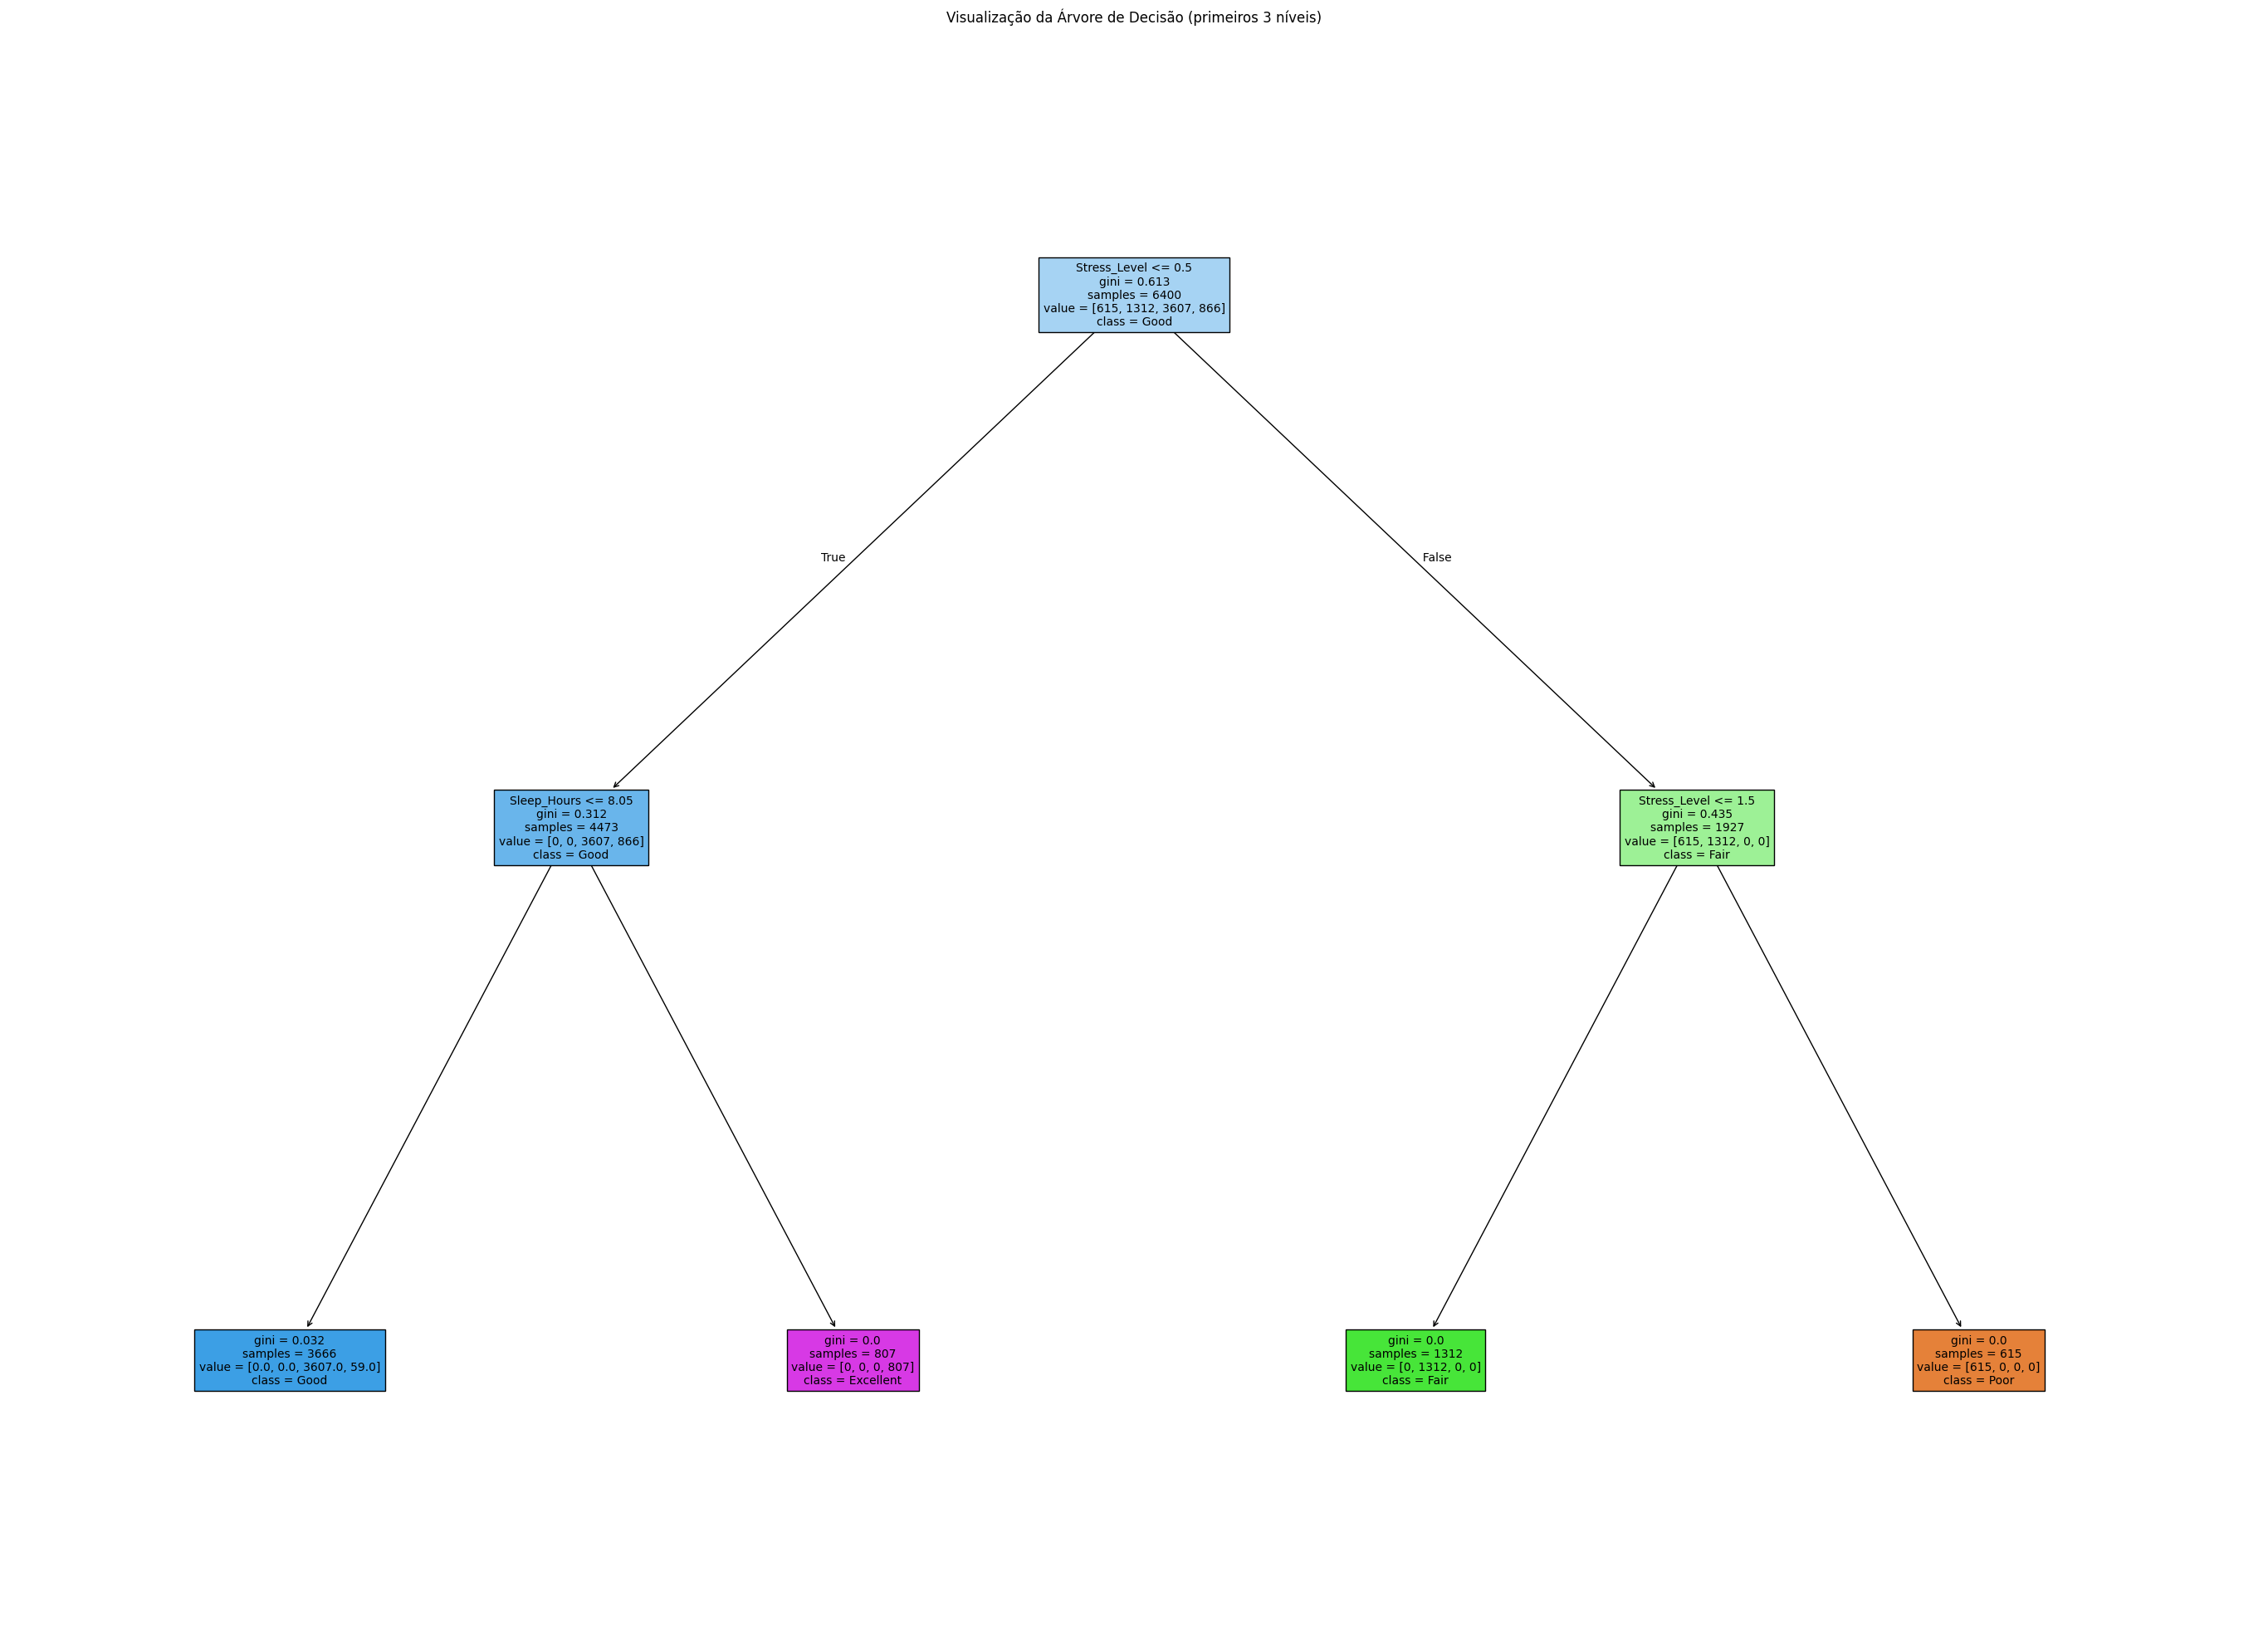

In [ ]:
# Nomes das classes para a legenda do gráfico
# O mapeamento foi: {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
class_names_list = ['Poor', 'Fair', 'Good', 'Excellent']

plt.figure(figsize=(35, 25))
plot_tree(ad_model,
          feature_names=X_train.columns,
          class_names=class_names_list,
          filled=True,
          max_depth=None, # Limita a profundidade da visualização
          fontsize=10)
plt.title("Visualização da Árvore de Decisão")
plt.show()

In [ ]:
# Nomes das classes para a legenda do gráfico
# O mapeamento foi: {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
class_names_list = ['Poor', 'Fair', 'Good', 'Excellent']

plt.figure(figsize=(35, 25))
plot_tree(ad_model,
          feature_names=X_train.columns,
          class_names=class_names_list,
          filled=True,
          max_depth=None, # Limita a profundidade da visualização
          fontsize=10)
plt.title("Visualização da Árvore de Decisão")
plt.show()